In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from __future__ import annotations

import argparse
import csv
import json
import os
import time
import matplotlib.pyplot as plt

plt.style.use('default')
from dataclasses import dataclass
from datetime import datetime
from pathlib import Path
from typing import Tuple

import jax
import jax.numpy as jnp
import numpy as np
import optax

# --- Project imports (assumed available in your package) ---
from diffwake.diffwake_jax.model import load_input, create_state
from diffwake.diffwake_jax.layout_runner import make_layout_runner
from diffwake.diffwake_jax.util import average_velocity_jax
from diffwake.diffwake_jax.turbine.operation_models import power as power_fn
from diffwake.diffwake_jax.simulator import simulate

def absolute_percentage_difference(a, b):
    return jnp.abs((a - b) / b) * 100


In [2]:
# Turn this into a dataclass maybe
data_dir = Path("data/horn")

# load configs
cfg = load_input(
    data_dir / "cc_hornsRev.yaml",
    data_dir / "vestas_v802MW.yaml"
)

# Create layout coordinates
layout_x = jnp.array([0.0, 500.0, 1000.0])
layout_y = jnp.array([0.0, 0.0, 0.0])

# Define single flow condition: 8 m/s, 270 degrees, 6% turbulence intensity
wind_speed = jnp.array([9.6])
wind_dir = jnp.array([jnp.deg2rad(270.0)])
ti = jnp.array([0.06])


# Update configuration
cfg = cfg.set(
    layout_x=layout_x,
    layout_y=layout_y,
    wind_speeds=wind_speed,
    wind_directions=wind_dir,
    turbulence_intensities=ti
)

# Create the simulation state
state = create_state(cfg)
result = simulate(state)
powers = power_fn(
    power_thrust_table=state.farm.power_thrust_table,
    velocities=result.u_sorted,
    air_density=state.flow.air_density,
    yaw_angles=state.farm.yaw_angles_sorted
)

print(f"Turbine powers (W): {powers}")
print(f"Total farm power (MW): {jnp.sum(powers) / 1e6}")


Turbine powers (W): [[1.1958496e+06 3.4931428e+05 3.5870728e+05]]
Total farm power (MW): 1.9038711786270142


## Loop through N turbines using JAX

In [10]:

N_turbines = [i for i in range(3, 100)]
farm_powers = []
turbine_powers = []
# for i in range(len(N_turbines)):
#     cfg = cfg.set(
#         layout_x=jnp.arange(0.0, 500.0 * (N_turbines[i] - 1) + 1, 500.0),
#         layout_y=jnp.zeros(N_turbines[i]),
#         wind_speeds=wind_speed,
#         wind_directions=wind_dir,
#         turbulence_intensities=ti
#     )
#     state = create_state(cfg)
#     result = simulate(state)
#     # state_final = state.replace(flow=state.flow.replace(u=result.u_sorted))
#     powers = power_fn(
#     power_thrust_table=state.farm.power_thrust_table,
#     velocities=result.u_sorted,
#     air_density=state.flow.air_density,
#     yaw_angles=state.farm.yaw_angles_sorted
# )
#     farm_powers.append(jnp.sum(powers))
# %%
# Optimized Loop using JAX vmap
import time

# 1. Define configurations
N_max = max(N_turbines)
padded_layouts = []
for n in N_turbines:
    # Real turbines
    x_real = jnp.arange(0.0, 500.0 * (n - 1) + 1, 500.0)
    y_real = jnp.arange(0.0, 10 * (n - 1) + 1, 10.0)
    
    # Padding (place far away to avoid interaction)
    n_pad = N_max - n
    x_pad = jnp.ones(n_pad) * 1e6
    y_pad = jnp.ones(n_pad) * 1e6
    
    layout = jnp.column_stack([
        jnp.concatenate([x_real, x_pad]),
        jnp.concatenate([y_real, y_pad])
    ])
    padded_layouts.append(layout)

padded_layouts = jnp.stack(padded_layouts) # (Batch, N_max, 2)

# 2. Create a base state for N_max turbines
cfg_max = cfg.set(
    layout_x=jnp.zeros(N_max),
    layout_y=jnp.zeros(N_max),
    wind_speeds=wind_speed,
    wind_directions=wind_dir,
    turbulence_intensities=ti
)
state_max = create_state(cfg_max)

# 3. Create the optimized runner
# make_layout_runner returns a JIT-compiled function that takes layout (N_max, 2)
runner = make_layout_runner(state_max, grid_resolution=3)

# 4. Run using vmap
vmap_runner = jax.vmap(runner)

print("Starting JAX optimized run (including compilation)...")
start_time = time.time()
all_results = vmap_runner(padded_layouts)

# Trigger completion
all_results.u_sorted.block_until_ready()
end_time = time.time()
print(f"Optimized run time (with JIT): {end_time - start_time:.4f} s")

# 5. Extract farm powers
# We need to sum only the first 'n' turbine powers for each simulation in the batch.
# all_results.u_sorted has shape (Batch, B, N_max, Ny, Nz)

def get_total_power(u_sorted, n):
    p = power_fn(
        power_thrust_table=state_max.farm.power_thrust_table,
        velocities=u_sorted,
        air_density=state_max.flow.air_density,
        yaw_angles=state_max.farm.yaw_angles_sorted
    )
    # p shape: (B, N_max)
    # Mask out the padded turbines
    mask = jnp.arange(N_max) < n
    return jnp.sum(p * mask)

vmap_get_power = jax.vmap(get_total_power)
farm_powers_opt = vmap_get_power(all_results.u_sorted, jnp.array(N_turbines))

print(f"First few optimized farm powers: {farm_powers_opt[:5]}")
# %%
# JAX results
farm_powers = farm_powers_opt.tolist()
farm_powers

# %%
# Verify optimized results
print(f"Original farm powers (first 5): {farm_powers[:5]}")
print(f"Optimized farm powers (first 5): {farm_powers_opt[:5]}")
diff_opt = jnp.abs(jnp.array(farm_powers) - farm_powers_opt)
print(f"Max difference: {jnp.max(diff_opt)}")
# %%

# FLORIS results for a single line
# floris_powers = [np.float64(1.9076175936870365),
#  np.float64(2.258380440961488),
#  np.float64(2.597878457446243),
#  np.float64(2.927408763914252),
#  np.float64(3.248355702746359),
#  np.float64(3.561923700751772),
#  np.float64(3.869109733950397),
#  np.float64(4.170730416815896),
#  np.float64(4.467456431032491),
#  np.float64(4.7598427202410205),
#  np.float64(5.048352611531561),
#  np.float64(5.333376526420024),
#  np.float64(5.615282949360591),
#  np.float64(5.895125752201492),
#  np.float64(6.173078221192365),
#  np.float64(6.449300019013923),
#  np.float64(6.723927483100588),
#  np.float64(6.997079952971724),
#  np.float64(7.268862849497039),
#  np.float64(7.539369911978159),
#  np.float64(7.808684944118079),
#  np.float64(8.076883222741625),
#  np.float64(8.344032654735642),
#  np.float64(8.610194738323003),
#  np.float64(8.87542536885886),
#  np.float64(9.13977551927715),
#  np.float64(9.403291818385119),
#  np.float64(9.666017045183747),
#  np.float64(9.927990553642074),
#  np.float64(10.189248639493552),
#  np.float64(10.449824858408736),
#  np.float64(10.709750303164732),
#  np.float64(10.969053846060799),
#  np.float64(11.227762351736217),
#  np.float64(11.485900864668524),
#  np.float64(11.74349277492031),
#  np.float64(12.000559965125237),
#  np.float64(12.257122941231495),
#  np.float64(12.513200949132436),
#  np.float64(12.76881207899293),
#  np.float64(13.023973358813354),
#  np.float64(13.278700838550764),
#  np.float64(13.533009665930381),
#  np.float64(13.786914154923965),
#  np.float64(14.040427847739279),
#  np.float64(14.293563571052845),
#  np.float64(14.546333487122808),
#  np.float64(14.798749140337472),
#  np.float64(15.050821499685465),
#  np.float64(15.30256099757369),
#  np.float64(15.553977565367807),
#  np.float64(15.805080665985558),
#  np.float64(16.05587932383468),
#  np.float64(16.30638215235384),
#  np.float64(16.55659737938588),
#  np.float64(16.806532870587233),
#  np.float64(17.056196151055296),
#  np.float64(17.305594425335904),
#  np.float64(17.554734595956095),
#  np.float64(17.803623280612193),
#  np.float64(18.052266828129984),
#  np.float64(18.300671333301988),
#  np.float64(18.54884265069642),
#  np.float64(18.796786407523257),
#  np.float64(19.0445080156344),
#  np.float64(19.292012682727925),
#  np.float64(19.539305422819563),
#  np.float64(19.786391066038906),
#  np.float64(20.033274267802565),
#  np.float64(20.279959517411754),
#  np.float64(20.52645114611764),
#  np.float64(20.772753334694013),
#  np.float64(21.018870120553345),
#  np.float64(21.264805404439265),
#  np.float64(21.5105629567258),
#  np.float64(21.756146423350998),
#  np.float64(22.001559331410526),
#  np.float64(22.246805094434563),
#  np.float64(22.491887017369564),
#  np.float64(22.736808301284697),
#  np.float64(22.98157204782126),
#  np.float64(23.226181263401937),
#  np.float64(23.470638863215438),
#  np.float64(23.71494767499099),
#  np.float64(23.959110442575938),
#  np.float64(24.203129829328837),
#  np.float64(24.447008421339497),
#  np.float64(24.69074873048652),
#  np.float64(24.934353197342286),
#  np.float64(25.17782419393448),
#  np.float64(25.42116402637268),
#  np.float64(25.664374937347976),
#  np.float64(25.907459108512995),
#  np.float64(26.150418662749182),
#  np.float64(26.393255666327832),
#  np.float64(26.635972130970746),
#  np.float64(26.878570015816297)]



Starting JAX optimized run (including compilation)...
Optimized run time (with JIT): 2.3207 s
First few optimized farm powers: [1.9645561e+06 2.3492965e+06 2.7230942e+06 3.0870775e+06 3.4426362e+06]
Original farm powers (first 5): [1964556.125, 2349296.5, 2723094.25, 3087077.5, 3442636.25]
Optimized farm powers (first 5): [1.9645561e+06 2.3492965e+06 2.7230942e+06 3.0870775e+06 3.4426362e+06]
Max difference: 0.0


In [18]:
# FLORIS results for a diagonal line
floris_powers = [np.float64(1.9645562562108774),
 np.float64(2.3492966002546325),
 np.float64(2.7230942093220984),
 np.float64(3.0870774890378416),
 np.float64(3.442636129442449),
 np.float64(3.7910005727420546),
 np.float64(4.133189856301405),
 np.float64(4.470035591158981),
 np.float64(4.80221730012604),
 np.float64(5.130294087499026),
 np.float64(5.454730058490803),
 np.float64(5.775914034301213),
 np.float64(6.09417470907613),
 np.float64(6.409792321231834),
 np.float64(6.7230076964049825),
 np.float64(7.0340293114472825),
 np.float64(7.343038862031034),
 np.float64(7.650195690756513),
 np.float64(7.9556403403014215),
 np.float64(8.259497428833578),
 np.float64(8.561877995829017),
 np.float64(8.862881430497424),
 np.float64(9.162597068521986),
 np.float64(9.461105523136963),
 np.float64(9.758479801823071),
 np.float64(10.054786248767067),
 np.float64(10.350085344755847),
 np.float64(10.644432389671932),
 np.float64(10.937878087728768),
 np.float64(11.23046905166806),
 np.float64(11.52224823906957),
 np.float64(11.813255331497876),
 np.float64(12.103527065282451),
 np.float64(12.393097521185172),
 np.float64(12.681998378968586),
 np.float64(12.970259141874191),
 np.float64(13.257907335203246),
 np.float64(13.544968682524678),
 np.float64(13.831467262485733),
 np.float64(14.117425648747824),
 np.float64(14.40286503519418),
 np.float64(14.687805348242788),
 np.float64(14.972265347836228),
 np.float64(15.256262718460171),
 np.float64(15.539814151356902),
 np.float64(15.822935418943501),
 np.float64(16.10564144231118),
 np.float64(16.38794635256891),
 np.float64(16.66988680677387),
 np.float64(16.951557483126056),
 np.float64(17.232966805795655),
 np.float64(17.51412358349398),
 np.float64(17.795035846937836),
 np.float64(18.075711151803816),
 np.float64(18.356156665499142),
 np.float64(18.636379209440275),
 np.float64(18.916385287738347),
 np.float64(19.196181109953),
 np.float64(19.475772610526466),
 np.float64(19.755165466000552),
 np.float64(20.034365110567432),
 np.float64(20.313376750271424),
 np.float64(20.5922053760673),
 np.float64(20.870855775881584),
 np.float64(21.149332545788806),
 np.float64(21.42764010039308),
 np.float64(21.70578268249026),
 np.float64(21.983764372075377),
 np.float64(22.26158909475159),
 np.float64(22.539260629590384),
 np.float64(22.816782616487384),
 np.float64(23.09415856305343),
 np.float64(23.37139185107683),
 np.float64(23.648485742589195),
 np.float64(23.925443385564293),
 np.float64(24.20226781927684),
 np.float64(24.478961979345605),
 np.float64(24.75552870248333),
 np.float64(25.03197073097387),
 np.float64(25.308290716895527),
 np.float64(25.584491226107723),
 np.float64(25.860574742017008),
 np.float64(26.136543669137076),
 np.float64(26.41240033645626),
 np.float64(26.68814700062504),
 np.float64(26.96378584897508),
 np.float64(27.239319002380448),
 np.float64(27.514748517970986),
 np.float64(27.790076391706883),
 np.float64(28.065304560823062),
 np.float64(28.340434906151206),
 np.float64(28.615469254326804),
 np.float64(28.890409379888023),
 np.float64(29.165257007272746),
 np.float64(29.44001381271975),
 np.float64(29.714681426079494),
 np.float64(29.989261432539664)]

for i in range(len(floris_powers)):
    floris_powers[i] *= 1e6

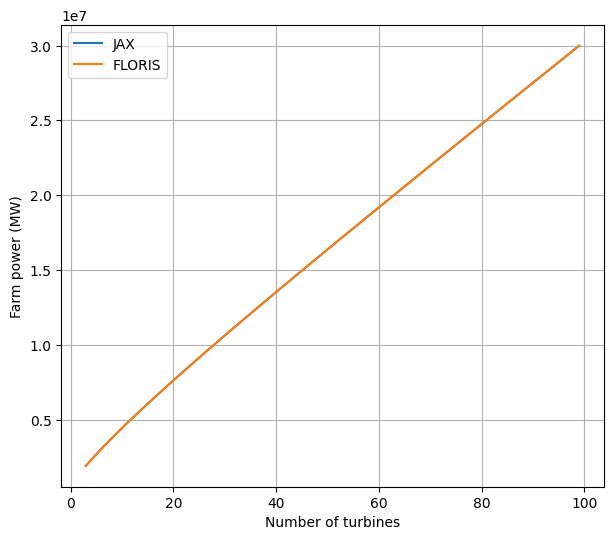

In [19]:
plt.figure(figsize=(7, 6))
plt.plot(N_turbines, farm_powers, label='JAX')
plt.plot(N_turbines, floris_powers, label='FLORIS')
plt.xlabel("Number of turbines")
plt.ylabel("Farm power (MW)")

plt.legend()
plt.grid()

In [20]:
diff = absolute_percentage_difference(jnp.array(farm_powers), jnp.array(floris_powers))
print(f"Absolute percentage difference: {diff}")

Absolute percentage difference: [6.36276036e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.04118562e-05 1.94920594e-05 3.66654276e-05 5.19398309e-05
 7.38410090e-05 1.09207904e-04 1.33868656e-04 1.70599233e-04
 1.97465924e-04 2.22216549e-04 2.57678825e-04 2.90574564e-04
 3.15351383e-04 3.49773414e-04 3.81987775e-04 4.12213965e-04
 4.40642412e-04 4.67439066e-04 4.92749561e-04 5.16702072e-04
 5.48552431e-04 5.78782579e-04 5.90162585e-04 6.17949874e-04
 6.44440239e-04 6.77796605e-04 6.93896960e-04 7.17025017e-04
 7.31638866e-04 7.60429946e-04 7.73598382e-04 7.93345796e-04
 8.12338374e-04 8.23812676e-04 8.48235039e-04 8.71773111e-04
 8.75171390e-04 8.91111558e-04 9.12723655e-04 9.27510962e-04
 9.35819233e-04 9.43866035e-04 9.40058730e-04 9.59225756e-04
 9.66561667e-04 9.73682269e-04 9.69701970e-04 9.87316133e-04
 9.83274425e-04 9.89780179e-04 9.85840219e-04 1.00226945e-03
 1.00826751e-03 1.00426446e-03 1.01980334e-03 1.01577

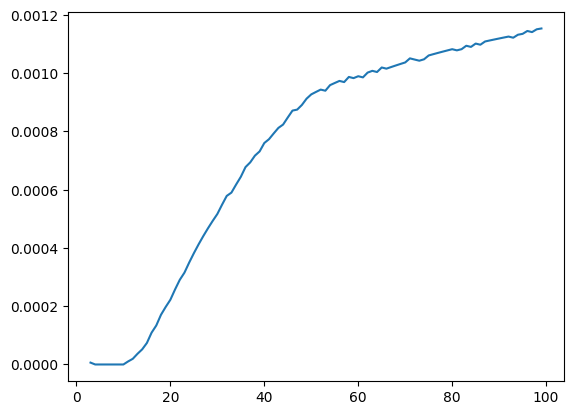

In [21]:
plt.plot(N_turbines, diff)